# Bibliotecas a serem usadas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

# Carregando o arquivo csv

In [ ]:
# Leitura do arquivo em questão
try:
  dados_combustivel = pd.read_csv('https://raw.githubusercontent.com/ccalmendra/ciencia-dados/refs/heads/main/dados/ap2-combustivel-producao.csv')
except:
  print('Arquivo não encontrado')

# Parte 1 -> leitura e indentificação

In [ ]:
# Linhas com valores ausentes
linhas_ausentes = dados_combustivel[dados_combustivel.isnull().any(axis=1)]
print("Linhas ausentes(NaN)")
print(linhas_ausentes)


# Plotando a soma dos valores ausentes
print("\n--- Visualização de Valores Ausentes por Coluna ---")
missing_values_count = dados_combustivel.isnull().sum()

# Filtrar colunas que realmente possuem valores ausentes
missing_values_count = missing_values_count[missing_values_count > 0]

if not missing_values_count.empty:
    print(missing_values_count)


# Valores duplicados
valores_duplicados = dados_combustivel[dados_combustivel.duplicated(keep = False)] #
print("\nValores duplicados")
print(valores_duplicados)

Linhas ausentes(NaN)
     Mês/Ano    Região             Estado  Produção Etanol Hidratado(m³/d)  \
3    08/2023  NORDESTE            Alagoas                            855.0   
10   08/2023     NORTE                 GO                           1004.0   
15   08/2023       NaN     Rio de Janeiro                              NaN   
18   08/2023       SUL  Rio Grande do Sul                              2.0   
27   07/2023       NaN          Tocantins                              NaN   
..       ...       ...                ...                              ...   
821  03/2019  NORDESTE         Pernambuco                           5557.0   
822  03/2019     NORTE           Rondônia                            112.0   
847  01/2019   SUDESTE       Minas Gerais                            546.0   
849  01/2019       SUL             Paraná                           3655.0   
852  08/2020   SUDESTE     Rio de Janeiro                          30784.0   

     Produção Etanol Anidro (m³/d)  
3    

# Análise dos outliers via gráficos

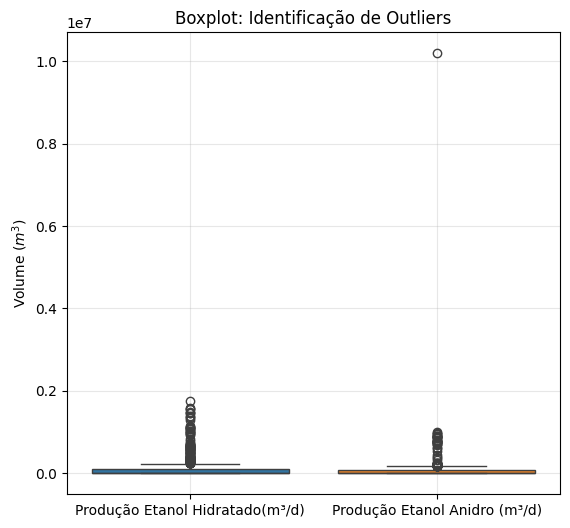

In [ ]:
# Boxplot para identificação visual dos outliers
cols_volume = ['Produção Etanol Hidratado(m³/d)', 'Produção Etanol Anidro (m³/d)']
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=dados_combustivel[cols_volume])
plt.title('Boxplot: Identificação de Outliers')
plt.ylabel('Volume ($m^3$)')
plt.grid(True, alpha=0.3)

In [ ]:
#Aqui, fiz um scatter plot interativo pra indentificar os outliers com mais precisão


# Aqui os indices das colunas são transformadas em uma coluna normal
dados_combustivel_empilhadas = dados_combustivel.melt(id_vars=['Mês/Ano', 'Região', 'Estado'],
                                                 value_vars=cols_volume,
                                                 var_name='Tipo Combustível',
                                                 value_name='Volume')

fig = px.scatter(dados_combustivel_empilhadas,
                 x=dados_combustivel_empilhadas.index,
                 y='Volume',
                 color='Tipo Combustível',
                 hover_data=['Mês/Ano', 'Estado', 'Região', 'Tipo Combustível', 'Volume'], # O que aparece no mouse
                 title='Scatter Plot Interativo - Identificação de Outliers',
                 labels={'index': 'Número das Linhas '})

fig.show()

# Visualmente falando, temos um valor muito inadequado em relação ao restante dos valores, mas, usaremos um método a frente para manipular os outliers.

In [ ]:
#Método de identificação -> IQR
#Calculamos Q1 (25%), Q3 (75%) e consideramos outlier tudo fora de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
def identificar_outliers(df, coluna):
  # Calcular Q1, Q3 e IQR apenas para a coluna numérica específica
  Q1 = df[coluna].quantile(0.25)
  Q3 = df[coluna].quantile(0.75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  # Identificar outliers na coluna específica
  outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
  return outliers


print("\n--- Outliers Identificados (Método IQR) ---")
for col in cols_volume:
    out = identificar_outliers(dados_combustivel, col)
    if not out.empty:
        print(f"Outliers em {col}:\n{out[['Estado', 'Mês/Ano', col]]}\n")


--- Outliers Identificados (Método IQR) ---
Outliers em Produção Etanol Hidratado(m³/d):
                 Estado  Mês/Ano  Produção Etanol Hidratado(m³/d)
0                 Goiás  08/2023                         661956.0
1           Mato Grosso  08/2023                         346609.0
2    Mato Grosso do Sul  08/2023                         378912.0
14         Minas Gerais  08/2023                         303552.0
16            São Paulo  08/2023                        1105928.0
..                  ...      ...                              ...
799        Minas Gerais  05/2019                         304513.0
801           São Paulo  05/2019                        1354345.0
803               Goiás  04/2019                         281750.0
805  Mato Grosso do Sul  04/2019                         275730.0
814           São Paulo  04/2019                         830469.0

[131 rows x 3 columns]

Outliers em Produção Etanol Anidro (m³/d):
           Estado  Mês/Ano  Produção Etanol Anidro

In [ ]:
padrao_data = r'^\d{2}/\d{4}$' # -> Formatação de data MM/AAAA

# Verifica datas que não seguem o padrão
datas_invalidas = dados_combustivel[~dados_combustivel['Mês/Ano'].astype(str).str.match(padrao_data, na=False)] # -> Aqui, usei uma formataçaõ pré-definda de data, e se a data não estiver em acordo, mostra ela
print("Datas fora do padrão MM/AAAA:")
print(datas_invalidas['Mês/Ano'].unique())

# Verifica Estados estranhos (ex: GO vs Goiás, Goias sem acento)
estados_unicos = dados_combustivel['Estado'].unique()
print(f"\nEstados encontrados (incluindo erros): {estados_unicos}")

Datas fora do padrão MM/AAAA:
['08/23' '2023-08' '08/2023_']

Estados encontrados (incluindo erros): ['Goiás' 'Mato Grosso' 'Mato Grosso do Sul' 'Alagoas' 'Bahia' 'Maranhão'
 'Paraíba' 'Pernambuco' 'Goias' 'GO' 'Pará' 'Tocantins' 'Espírito Santo'
 'Minas Gerais' 'Rio de Janeiro' 'São Paulo' 'Paraná' 'Rio Grande do Sul'
 'Piauí' 'Sergipe' 'Rio Grande do Norte' 'Amazonas' 'Rondônia' 'Para'
 'Maranhao']


# Parte 2 -> Tratamento dos dados

In [ ]:
from plotly import data
#removendo as duplicatas
dados_combustivel = dados_combustivel.drop_duplicates()

#consertando as datas

def corrigir_data(data):
    if pd.isnull(data): return data
    data = str(data).strip().replace('_', '') # Remove typo '_'

    # Caso 2023-08 -> 08/2023
    if '-' in data:
        partes = data.split('-')
        if len(partes[0]) == 4: # Formato YYYY-MM
            return f"{partes[1]}/{partes[0]}"

    # Caso 08/23 -> 08/2023
    if '/' in data:
        partes = data.split('/')
        if len(partes[1]) == 2: # Formato MM/YY
            return f"{partes[0]}/20{partes[1]}"
    return data

dados_combustivel['Mês/Ano'] = dados_combustivel['Mês/Ano'].apply(corrigir_data)
print(dados_combustivel['Mês/Ano'].unique())

# Correção do nomes dos estados

mapa_estados = {
    'Goias': 'Goiás',
    'GO': 'Goiás',
    'Maranhao': 'Maranhão',
    'Para': 'Pará',

}
dados_combustivel['Estado'] = dados_combustivel['Estado'].replace(mapa_estados)
print(dados_combustivel['Estado'].unique())

# Correção dos valores ausentes para região/estado
# Se tivermos um valor sem o Estado, podemos dizer que é inutilizável. Afinal(Considerando o caso Região-> True , Estado->False), se tivermos a região,
# mas não o estado, não teremos uma análise de dados consistente
# E, se tivemos estado e não região, através de um dicionário pré-definido, adicionamos o valor região onde existe NAN baseado no estado
dados_combustivel = dados_combustivel.dropna(subset=['Estado'])

mapa_regioes = {
    'Acre': 'NORTE', 'Alagoas': 'NORDESTE', 'Amapá': 'NORTE', 'Amazonas': 'NORTE',
    'Bahia': 'NORDESTE', 'Ceará': 'NORDESTE', 'Distrito Federal': 'CENTRO OESTE',
    'Espírito Santo': 'SUDESTE', 'Goiás': 'CENTRO OESTE',
    'Maranhão': 'NORDESTE',
    'Mato Grosso': 'CENTRO OESTE', 'Mato Grosso do Sul': 'CENTRO OESTE',
    'Minas Gerais': 'SUDESTE', 'Pará': 'NORTE', 'Paraíba': 'NORDESTE',
    'Paraná': 'SUL', 'Pernambuco': 'NORDESTE', 'Piauí': 'NORDESTE',
    'Rio de Janeiro': 'SUDESTE', 'Rio Grande do Norte': 'NORDESTE',
    'Rio Grande do Sul': 'SUL', 'Rondônia': 'NORTE', 'Roraima': 'NORTE',
    'Santa Catarina': 'SUL', 'São Paulo': 'SUDESTE', 'Sergipe': 'NORDESTE',
    'Tocantins': 'NORTE'
}


# A função fillna só age onde está vazio. Onde já tem região, ele mantém.
dados_combustivel['Região'] = dados_combustivel['Região'].fillna(dados_combustivel['Estado'].map(mapa_regioes))



print(dados_combustivel[['Produção Etanol Hidratado(m³/d)','Produção Etanol Anidro (m³/d)']].isnull().sum())



['08/2023' '07/2023' '06/2023' '05/2023' '04/2023' '03/2023' '02/2023'
 '01/2023' '12/2022' '11/2022' '10/2022' '09/2022' '08/2022' '07/2022'
 '06/2022' '05/2022' '04/2022' '03/2022' '02/2022' '01/2022' '12/2021'
 '11/2021' '10/2021' '09/2021' '08/2021' '07/2021' '06/2021' '05/2021'
 '04/2021' '03/2021' '02/2021' '01/2021' '12/2020' '11/2020' '10/2020'
 '09/2020' '08/2020' '07/2020' '06/2020' '05/2020' '04/2020' '03/2020'
 '02/2020' '01/2020' '12/2019' '11/2019' '10/2019' '09/2019' '08/2019'
 '07/2019' '06/2019' '05/2019' '04/2019' '03/2019' '02/2019' '01/2019']
['Goiás' 'Mato Grosso' 'Mato Grosso do Sul' 'Alagoas' 'Bahia' 'Maranhão'
 'Paraíba' 'Pernambuco' 'Pará' 'Tocantins' 'Espírito Santo' 'Minas Gerais'
 'Rio de Janeiro' 'São Paulo' 'Paraná' 'Rio Grande do Sul' 'Piauí'
 'Sergipe' 'Rio Grande do Norte' 'Amazonas' 'Rondônia']
Produção Etanol Hidratado(m³/d)     16
Produção Etanol Anidro (m³/d)      142
dtype: int64


In [ ]:
# Colunas de volume que estamos analisando
cols_volume = ['Produção Etanol Hidratado(m³/d)', 'Produção Etanol Anidro (m³/d)']

print("Valores ausentes ANTES do preenchimento pela mediana:")
print(dados_combustivel[cols_volume].isnull().sum())

for col in cols_volume:
    # Calcular a mediana de cada estado para a coluna atual
    mediana_por_estado = dados_combustivel.groupby('Estado')[col].transform('median')

    # Preencher os valores ausentes com a mediana calculada por estado
    dados_combustivel[col] = dados_combustivel[col].fillna(mediana_por_estado)

print("\nValores ausentes DEPOIS do preenchimento pela mediana:")
print(dados_combustivel[cols_volume].isnull().sum())

ausente_anidro = ['Produção Etanol Anidro (m³/d)']
print("\nValores ausentes que ainda persistem")
print(dados_combustivel[ausente_anidro].isnull().sum())

for col in ausente_anidro:
    # Preencher os valores ausentes com o zero. são tantos valores, que a mediana se torna inacessível
    # então, o zero parece ser uma solução sólida
    dados_combustivel[col] = dados_combustivel[col].fillna(0)

print("\nValores ausentes que ainda persistem")
print(dados_combustivel[ausente_anidro].isnull().sum())

Valores ausentes ANTES do preenchimento pela mediana:
Produção Etanol Hidratado(m³/d)     16
Produção Etanol Anidro (m³/d)      142
dtype: int64

Valores ausentes DEPOIS do preenchimento pela mediana:
Produção Etanol Hidratado(m³/d)     0
Produção Etanol Anidro (m³/d)      90
dtype: int64

Valores ausentes que ainda persistem
Produção Etanol Anidro (m³/d)    90
dtype: int64

Valores ausentes que ainda persistem
Produção Etanol Anidro (m³/d)    0
dtype: int64


 # Ponto a ser detalhado: Se removermos os o valor em disparate que identificou-se lá atrás, os "outliers" restantes não são disparates em si, mas pontos de análise úteis e interessantes para a próxima parte. Então, a estratégia, é apenas remover o valor em disparate

In [ ]:
dados_combustivel = dados_combustivel[dados_combustivel['Produção Etanol Anidro (m³/d)'] < 5000000]


# Parte 3 -> Visualização dos dados

Quais são os estados com maior produção dos dois tipos de combustível em
cada ano.

Gerando gráfico: Maior Produção por Ano...


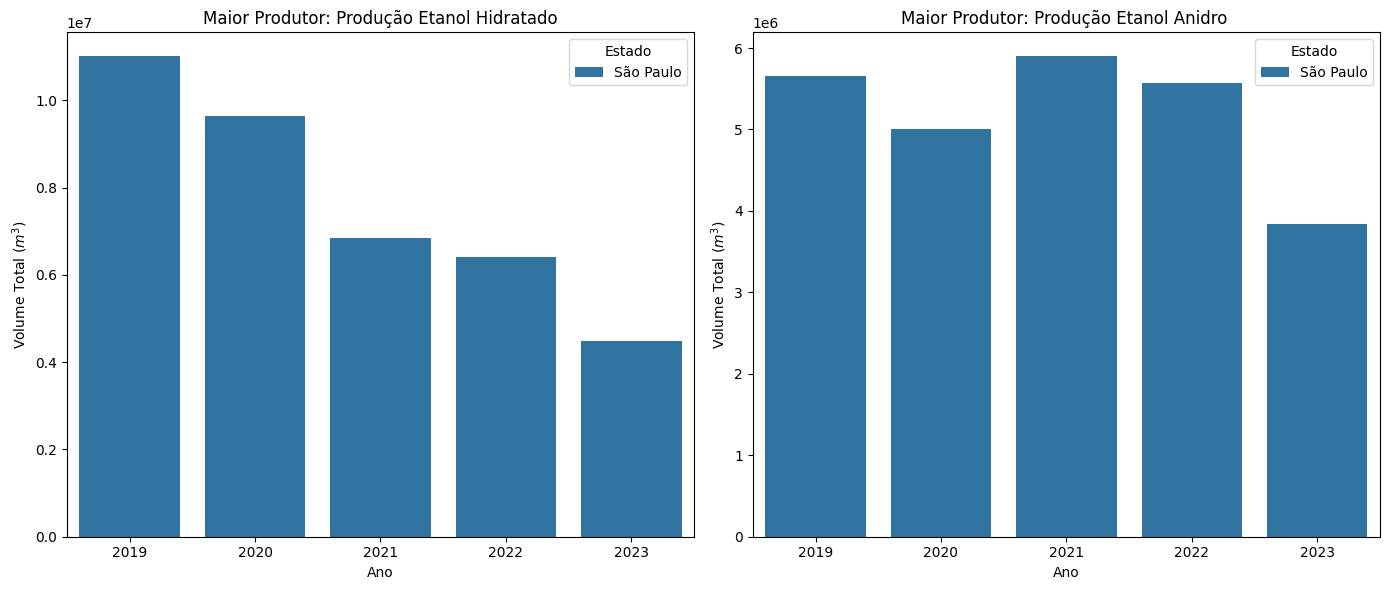

In [ ]:
# Criação de uma coluna Ano
dados_combustivel['Ano'] = dados_combustivel['Mês/Ano'].apply(lambda x: x.split('/')[1]) # -> Aqui, com uma função lambda, faço um  split a partir do ponto que tem a barra que separa ano/mês

# Estados com maior produção dos dois tipos em cada ano
print("Gerando gráfico: Maior Produção por Ano...")
dados_ano_combustivel = dados_combustivel.groupby(['Ano', 'Estado'])[cols_volume].sum().reset_index()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate(cols_volume):
    # Pega o índice do valor máximo para cada ano
    idx_max = dados_ano_combustivel.groupby('Ano')[col].idxmax()
    top_estados = dados_ano_combustivel.loc[idx_max]

    sns.barplot(data=top_estados, x='Ano', y=col, hue='Estado', ax=axes[i], dodge=False)
    axes[i].set_title(f'Maior Produtor: {col.split("(")[0]}')
    axes[i].set_ylabel('Volume Total ($m^3$)')

plt.tight_layout()
plt.show()

Como foi a evolução ao longo dos anos do volume de produção por região,
diferenciando cada tipo de combustível.

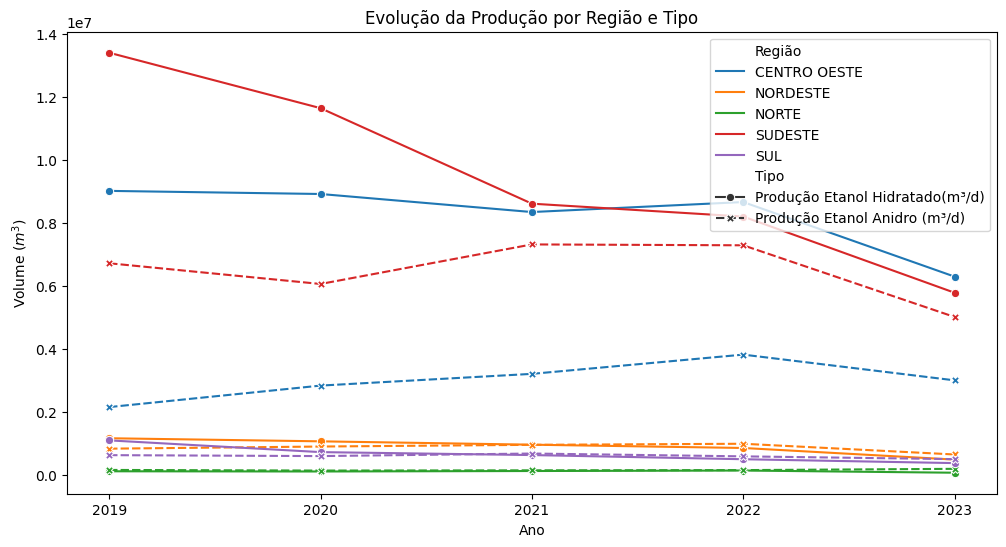

In [ ]:
dados_ano_regiao = dados_combustivel.groupby(['Ano', 'Região'])[cols_volume].sum().reset_index()

dados_novo = dados_ano_regiao.melt(id_vars=['Ano', 'Região'], value_vars=cols_volume, var_name='Tipo', value_name='Volume') # -> O melted mescla as colunas Ano e região com as colunas da variaveis cols_volume
# Criando uma nova coluna

plt.figure(figsize=(12, 6))
sns.lineplot(data=dados_novo, x='Ano', y='Volume', hue='Região', style='Tipo', markers=True)
plt.title('Evolução da Produção por Região e Tipo')
plt.ylabel('Volume ($m^3$)')
plt.show()

Quais estados tiveram aumento de produção de etanol hidratado no período
observado?

--- Estados com Aumento de Produção (Etanol Hidratado) ---
                 Estado       Variação
6           Mato Grosso  130887.791667
20            Tocantins     833.666667
16       Rio de Janeiro     -48.321429
11                 Pará     -64.805556
5              Maranhão    -133.250000
1              Amazonas    -290.166667
15    Rio Grande do Sul    -326.166667
17             Rondônia    -418.800000
13                Piauí    -830.428571
2                 Bahia   -3909.625000
14  Rio Grande do Norte   -4149.904762
18              Sergipe   -5564.766667
10              Paraíba   -9128.844156
3        Espírito Santo   -9194.345455
0               Alagoas  -14500.111111
12           Pernambuco  -20666.500000
7    Mato Grosso do Sul  -35812.770833
9                Paraná  -44325.625000
8          Minas Gerais  -64908.775000
4                 Goiás -148861.704545
19            São Paulo -355584.125000


/tmp/ipython-input-2575428084.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




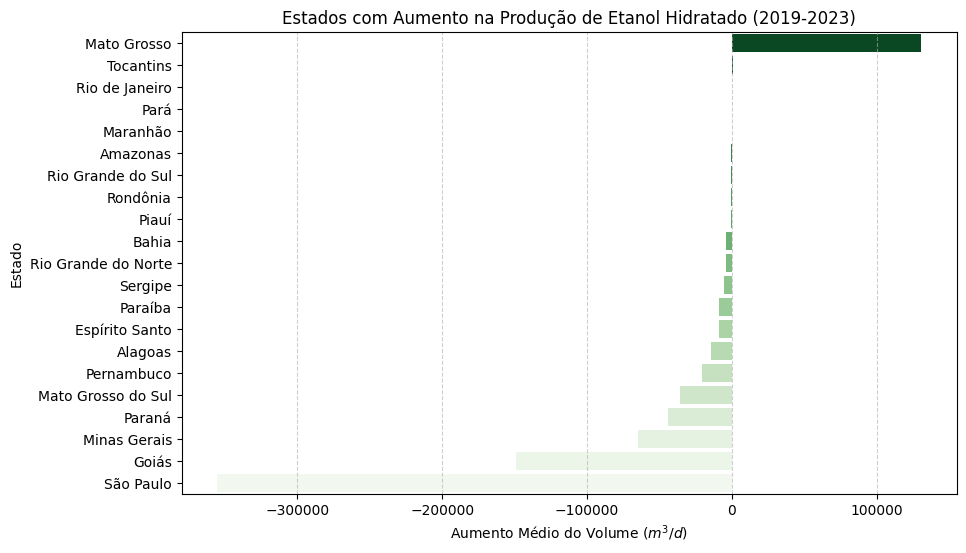

In [ ]:





# Agrupamos para saber quanto cada estado produziu em média em 2019, 2020, etc.
dados_anual = dados_combustivel.groupby(['Estado', 'Ano'])['Produção Etanol Hidratado(m³/d)'].mean().unstack()

# 3. Cálculo do Delta (Diferença: Último Ano - Primeiro Ano)
deltas = []
for estado in dados_anual.index:
    serie = dados_anual.loc[estado].dropna() # Pega os anos que o estado tem dados

    inicio = serie.iloc[0]  # Média do primeiro ano disponível (ex: 2019)
    fim = serie.iloc[-1]    # Média do último ano disponível (ex: 2023)
    variacao = fim - inicio
    deltas.append({'Estado': estado, 'Variação': variacao})

# Criar DataFrame com os resultados e ordenar
df_resultado = pd.DataFrame(deltas).sort_values('Variação', ascending=False)

# Filtrar apenas quem teve AUMENTO (Variação > 0)
estados_aumento = df_resultado#[df_resultado['Variação'] > 0]

print("--- Estados com Aumento de Produção (Etanol Hidratado) ---")
print(estados_aumento)


plt.figure(figsize=(10, 6))
sns.barplot(data=estados_aumento, x='Variação', y='Estado', palette='Greens_r')
plt.title('Estados com Aumento na Produção de Etanol Hidratado (2019-2023)')
plt.xlabel('Aumento Médio do Volume ($m^3/d$)')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

Quais estados tiveram queda de produção abaixo do desvio padrão de etanol
anidro no período observado?

Desvio Padrão Global (Etanol Anidro): 151563.84 m³/d

--- Estados com Queda de Produção (Abaixo do Desvio Padrão) ---
       Estado  Queda (m³/d)  Produção Final
5     Sergipe  -1604.933333     2541.400000
1     Paraíba  -1381.980519    18443.428571
3  Pernambuco   -972.812500    14039.500000
0    Maranhão   -625.475000    17129.400000
4       Piauí   -455.285714     2572.000000
2        Pará   -419.972222     5116.250000


/tmp/ipython-input-4199490999.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




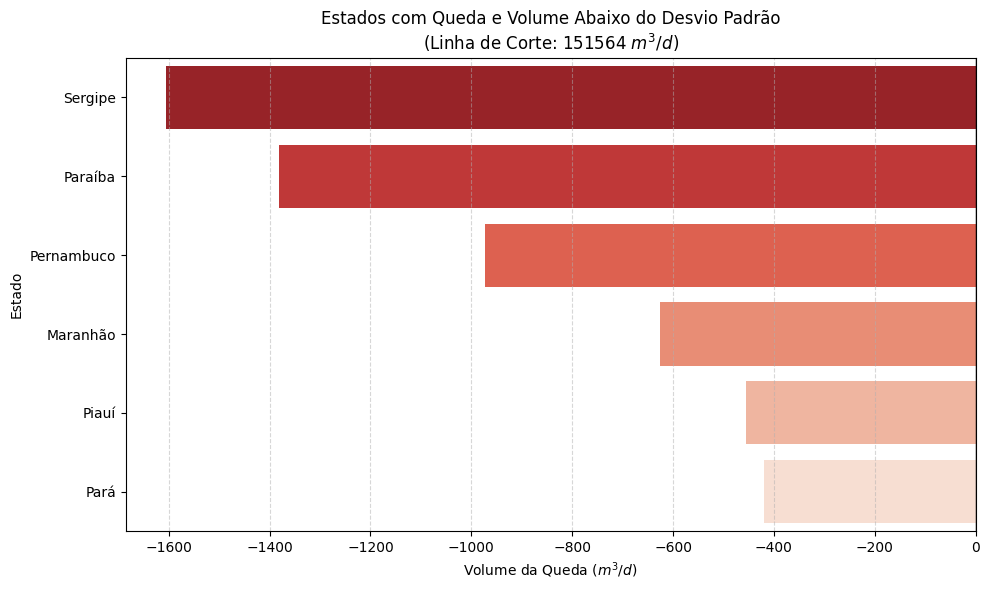

In [ ]:
col_anidro = 'Produção Etanol Anidro (m³/d)'

# Cálculo do Desvio Padrão Global de todo o período (Linha de Corte)
std_anidro = dados_combustivel[col_anidro].std()
print(f"Desvio Padrão Global (Etanol Anidro): {std_anidro:.2f} m³/d")

# 2. Análise da Evolução (Média Anual por Estado)
# Agrupa por Estado e Ano para ver a trajetória
dados_anual_Et = dados_combustivel.groupby(['Estado', 'Ano'])['Produção Etanol Anidro (m³/d)'].mean().unstack()

resultados_queda = []

# Iterar sobre os estados únicos
for estado in dados_anual_Et.index:
    serie = dados_anual_Et.loc[estado].dropna()
    inicio = serie.iloc[0]  # Média do primeiro ano
    fim = serie.iloc[-1]    # Média do último ano
    delta = fim - inicio    # Variação

        #  Produção Final é menor que o Desvio Padrão Global (fim < std_anidro)
    if delta < 0 and fim < std_anidro:
            resultados_queda.append({
                'Estado': estado,
                'Queda (m³/d)': delta,
                'Produção Final': fim
            })


if resultados_queda:
    dados_queda = pd.DataFrame(resultados_queda).sort_values('Queda (m³/d)')
    print("\n--- Estados com Queda de Produção (Abaixo do Desvio Padrão) ---")
    print(dados_queda[['Estado', 'Queda (m³/d)', 'Produção Final']])


    plt.figure(figsize=(10, 6))
    sns.barplot(data=dados_queda, x='Queda (m³/d)', y='Estado', palette='Reds_r')
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f'Estados com Queda e Volume Abaixo do Desvio Padrão\n(Linha de Corte: {std_anidro:.0f} $m^3/d$)', fontsize=12)
    plt.xlabel('Volume da Queda ($m^3/d$)')
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

